# IBM Data Science Capstone Project

##### This notebook will be used to complete the IBM Data Science online courses' final project, related to geodata and the use of the location data-based Foursquare API

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.style.use('ggplot') 

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Description of the Project

The aim of this project is to provide potential business starters with some orientation regarding where to locate their economic activities in the regions of Spain. Since both Catalonia and Madrid represent the largest contribution to the Gross Domestic Product (GDP) of Spain ([1](https://es.wikipedia.org/wiki/Anexo:Provincias_de_Espa%C3%B1a_por_PIB)), they are the most suited to establish a new business and thus, the focus of this project.

By scraping all of the municipalities from both cities and their contributions to the Spanish GDP, we will restrict the analysis to the ones that generate the most; then, an analysis of the local venues will be carried out to get a general idea of the type of businesses that are successful in the cities.
Finally, conclusions and a general recommendation will be drawn.

* **Required Data and its' scraping**

First, we need to know the different areas that constitute both cities. Luckily for us, we can find this information in Wikipedia (([2](https://en.wikipedia.org/wiki/Municipalities_of_Catalonia)), ([3](https://en.wikipedia.org/wiki/List_of_municipalities_in_the_Community_of_Madrid))).
All of the necessary GDP-related data can also be found in ([4](http://www.idescat.cat/pub/?id=pibc&n=13830&by=mun&lang=es&f=ssv)) for Catalonia and in ([5](https://datosmacro.expansion.com/mercado-laboral/renta/espana/municipios/madrid/madrid)) for Madrid.

The geographical coordinates of the municipalities will be scraped by the Geocoder Python package ([6](https://geocoder.readthedocs.io/index.html)), and the local venues will be obtained Foursquare's API ([7](https://developer.foursquare.com/docs/places-api/)).

---

1. **Since Github is not able to show maps generated by the Folium package (which will be used for this project), it is highly advised to read this notebook under Nbviewer ([8](https://nbviewer.jupyter.org/)).**
2. **Unfortunately, after consulting several governmental and official sources, the most up-to-date GDP data that is available (for each municipality) was from 2018-2019. Typically, this data is updated on a more regular basis for a higher regional division (autonomous communities, such as Andalusia or Catalonia) than the one that this project works with.**
3. **In the particular case of Catalonia, only the most populated municipalities had data (that is, for the 2018-2019 period of time). However, this does not cause any trouble, given that the aim of the project is to analyse the regions that generate the biggest contribution to the GDP.**
4. **Since the data is pre-Covid era, the results from this analysis might not reflect the finantial situation that the world is currently going through. Thus, do not take the contents of this notebook as any kind of financial advise. Bear in mind that this just a Data Science project to put into practice the contents of IBM's Data Science courses.**

## Table of Contents
1. [Web Scraping and Data Cleaning](#1)<br>
    1.1 [Catalonia](#1.1)<br>
    1.2 [Madrid](#1.2)<br>
2. [GeoData obtention](#2)<br>
    2.1 [Coordinates](#2.1)<br>
    2.2 [Venues via FourSquare's API](#2.2)<br> 
3. [Venue Analysis](#3)<br>
    3.1 [Catalonia](#3.1)<br>
    3.2 [Madrid](#3.2)<br>
4. [Clustering with KMeans](#4)<br>
    4.1 [Catalonia](#4.1)<br>
    4.2 [Madrid](#4.2)<br>
5. [Conclusion](#5)<br>

## 1. Web Scraping and Data Cleaning
<a id='1'></a>

### 1.1 Catalonia
<a id='1.1'></a>

We start by downloading Catalonia's data from ([4](http://www.idescat.cat/pub/?id=pibc&n=13830&by=mun&lang=es&f=ssv)). This CSV file includes both the names of the municipalities and its' GDP-related values, so luckily, it is not necessary to web scrape ([2](https://en.wikipedia.org/wiki/Municipalities_of_Catalonia)). Since a read request results in an error 403 (a forbidden request), we first download and then read the file:

In [2]:
gdp_cat = pd.read_csv("t13830mun.csv", skiprows=9, sep=";").reset_index(drop=True)
print(gdp_cat.dtypes)
print("\n Number of rows:", gdp_cat.shape[0])
gdp_cat.head()

Codi                                         object
Literal                                      object
PIB milions d'euros                          object
PIB  per habitant. Milers d'euros            object
PIB  per habitant. Índex Catalunya = 100    float64
dtype: object

 Number of rows: 24


,Codi,Literal,PIB milions d'euros,PIB per habitant. Milers d'euros,PIB per habitant. Índex Catalunya = 100
0,Badalona,"4468,6","20,4","62,0",NaN
1,Barcelona,"78817,6","48,5","147,3",NaN
2,Castelldefels,"1464,8","22,1","67,0",NaN
3,Cerdanyola del Vallès,"2120,8","37,0","112,5",NaN
4,Cornellà de Llobregat,"2988,1","34,0","103,4",NaN


We drop the last row and unnecessary columns and rename the ones we want to keep. Since numerical columns are interpreted as object-type (string), we also need to change its' format to numerical. We can achieve this by changing the "," separator into "." to convert them into float data:

In [3]:
gdp_cat.drop(index=gdp_cat.shape[0]-1, columns=gdp_cat.columns[range(2, len(gdp_cat.columns))], inplace=True)
gdp_cat.rename(columns={"Codi":"Municipalities", "Literal":"GDP (millions of €)"}, inplace=True)

floats = np.zeros(gdp_cat.shape[0])
i = 0
# Fills an empty array with the numerical values of the GDP converted into float data
for numb in gdp_cat["GDP (millions of €)"]: 
    floats[i] = numb.replace(",", ".")
    i = i + 1
    
gdp_cat["GDP (millions of €)"] = floats
print(gdp_cat.dtypes)
gdp_cat.head()

Municipalities          object
GDP (millions of €)    float64
dtype: object


,Municipalities,GDP (millions of €)
0,Badalona,4468.6
1,Barcelona,78817.6
2,Castelldefels,1464.8
3,Cerdanyola del Vallès,2120.8
4,Cornellà de Llobregat,2988.1


We can now see that the data types of both columns are corrected. 

Finally, we will sort the dataframe by the municipalities that contribute the most to the GDP, and keep the top 3 to run the geodata analysis.

In [4]:
gdp_cat = gdp_cat.sort_values(by=["GDP (millions of €)"], ascending=False).reset_index(drop=True)
gdp_cat.drop(index=range(3, gdp_cat.shape[0]), inplace=True)
gdp_cat

,Municipalities,GDP (millions of €)
0,Barcelona,78817.6
1,L'Hospitalet de Llobregat,6761.0
2,Tarragona,5349.6


### 1.2 Madrid
<a id='1.2'></a>

For this case, we will use the BeautifulSoup python package to web scrape the data from ([5](https://datosmacro.expansion.com/mercado-laboral/renta/espana/municipios/madrid/madrid)). Just like before, the main goal is to build a dataframe for the top 3 municipalities from Madrid that contribute the most to the national GDP.

In [5]:
bf = BeautifulSoup(requests.get("https://datosmacro.expansion.com/mercado-laboral/renta/espana/municipios/madrid/madrid").text, "html.parser")
table = bf.find("table")

# The names of the municipalities are nested in <a> tags, alongside with the city and the autonomous community they are located
# in. This means that, in order to get just the municipalities, we will need to extract the elements whose index are a
# multiple of three:
mad_mun = [table.findAll("a")[i].text for i in range(0, int(len(table.findAll("a")))) if i%3==0]   
                                              
mad_mun

['Pozuelo de Alarcón',
 'Boadilla del Monte',
 'Alcobendas',
 'Majadahonda',
 'Torrelodones']

In [6]:
# Same thing for the gdp values, nested in the <td> tag. We also need to delete the € symbol from them, turn them into float data
# and multiply them by 1000, given that python interprets "." as a decimal separator. The information we require is assigned to 
# indices 1, 7, 13, 19 and 25 (the distance between our elements is 5 indices).
mad_gdp = []
for i in [1, 7, 13, 19, 25]:   
    mad_gdp.append(float(table.findAll("td", {"class": "numero"})[i].text.replace("€", "").replace(".", "")))
    
mad_gdp

[79506.0, 61910.0, 60842.0, 54506.0, 54123.0]

We create a new database with Madrid's GDP data and take the top 3:

In [7]:
gdp_mad = pd.DataFrame(zip(mad_mun, mad_gdp), columns=["Municipalities", "GDP (millions of €)"])
print(gdp_mad.dtypes)
print("\n Number of rows:", gdp_mad.shape[0])
gdp_mad.head()

Municipalities          object
GDP (millions of €)    float64
dtype: object

 Number of rows: 5


,Municipalities,GDP (millions of €)
0,Pozuelo de Alarcón,79506.0
1,Boadilla del Monte,61910.0
2,Alcobendas,60842.0
3,Majadahonda,54506.0
4,Torrelodones,54123.0


In [8]:
gdp_mad = gdp_mad.sort_values(by=["GDP (millions of €)"], ascending=False).reset_index(drop=True)
gdp_mad.drop(index=range(3,5), inplace=True)
gdp_mad

,Municipalities,GDP (millions of €)
0,Pozuelo de Alarcón,79506.0
1,Boadilla del Monte,61910.0
2,Alcobendas,60842.0


## 2. GeoData obtention
<a id='2'></a>

### 2.1 Coordinates
<a id='2.1'></a>

For this section, we will search the coordinates for each of the municipalities. To achieve this, geocode can be used as follows:

In [9]:
# We create empty lists for the coordinates to later append them to our dataframes
mad_lat = []
mad_long = []
cat_lat = []
cat_long = []
geolocator = Nominatim(user_agent="capstone")
for mad, cat in zip(gdp_mad["Municipalities"].values, gdp_cat["Municipalities"].values):
    location_cat = geolocator.geocode(cat + ", Cataluña")
    location_mad = geolocator.geocode(mad + ", Madrid")
    cat_lat.append(location_cat.latitude)
    cat_long.append(location_cat.longitude)
    mad_lat.append(location_mad.latitude)
    mad_long.append(location_mad.longitude)

In [10]:
gdp_cat["Latitude"] = cat_lat
gdp_cat["Longitude"] = cat_long
gdp_mad["Latitude"] = mad_lat
gdp_mad["Longitude"] = mad_long
print(gdp_cat.dtypes)
gdp_cat.head()

Municipalities          object
GDP (millions of €)    float64
Latitude               float64
Longitude              float64
dtype: object


,Municipalities,GDP (millions of €),Latitude,Longitude
0,Barcelona,78817.6,41.382894,2.177432
1,L'Hospitalet de Llobregat,6761.0,41.359860,2.099793
2,Tarragona,5349.6,41.117236,1.254606


In [11]:
# create map of Catalonia using latitude and longitude values
map_cat = folium.Map(location=[geolocator.geocode("Barcelona").latitude, geolocator.geocode("Barcelona").longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(gdp_cat['Latitude'], gdp_cat['Longitude'], gdp_cat['Municipalities']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cat)  
    
map_cat

In [12]:
print(gdp_mad.dtypes)
gdp_mad.head()

Municipalities          object
GDP (millions of €)    float64
Latitude               float64
Longitude              float64
dtype: object


,Municipalities,GDP (millions of €),Latitude,Longitude
0,Pozuelo de Alarcón,79506.0,40.434653,-3.814834
1,Boadilla del Monte,61910.0,40.405349,-3.876466
2,Alcobendas,60842.0,40.540008,-3.635849


In [13]:
# create map of Madrid using latitude and longitude values
map_mad = folium.Map(location=[geolocator.geocode("Madrid").latitude, geolocator.geocode("Madrid").longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(gdp_mad['Latitude'], gdp_mad['Longitude'], gdp_mad['Municipalities']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mad)  
    
map_mad

### 2.2 Venues via FourSquare's API
<a id='2.2'></a>

We start by defining our Foursquare credentials:

In [14]:
CLIENT_ID = input("Foursquare ID: ")
CLIENT_SECRET = input("Foursquare Secret: ")
ACCESS_TOKEN = input("FourSquare Access Token: ")
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

Now, we define a function that gets the nearby venues of a given location by using Foursquare's API:

In [15]:
def venues(muns, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for mun, lat, lng in zip(muns, latitudes, longitudes):
            
        # request URL for Foursquare's API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            mun, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality Latitude', 
                  'Municipality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
venues_cat = venues(gdp_cat["Municipalities"], gdp_cat["Latitude"], gdp_cat["Longitude"])
venues_mad = venues(gdp_mad["Municipalities"], gdp_mad["Latitude"], gdp_mad["Longitude"])
print("\n Number of venues:", venues_cat.shape[0])
print("\n Number of venue categories:", len(venues_cat["Venue Category"].unique()))
venues_cat


 Number of venues: 210

 Number of venue categories: 77


,Municipality,Municipality Latitude,Municipality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barcelona,41.382894,2.177432,Barrio Gótico,41.383660,2.177290,Neighborhood
1,Barcelona,41.382894,2.177432,Gelaaati! di Marco,41.383186,2.177369,Ice Cream Shop
2,Barcelona,41.382894,2.177432,La Alcoba Azul,41.382833,2.175506,Spanish Restaurant
3,Barcelona,41.382894,2.177432,Plaça de Sant Felip Neri,41.383378,2.175152,Plaza
4,Barcelona,41.382894,2.177432,Pont del Carrer del Bisbe,41.383310,2.176413,Bridge
...,...,...,...,...,...,...,...
205,Tarragona,41.117236,1.254606,La Botifarra,41.114216,1.250442,Restaurant
206,Tarragona,41.117236,1.254606,Fleca Flaqué,41.115881,1.249509,Bakery
207,Tarragona,41.117236,1.254606,Domino's Pizza,41.116730,1.250107,Pizza Place
208,Tarragona,41.117236,1.254606,Zara,41.116462,1.249158,Clothing Store


In [17]:
print("\n Number of venues:", venues_mad.shape[0])
print("\n Number of venue categories:", len(venues_mad["Venue Category"].unique()))
venues_mad.head()


 Number of venues: 46

 Number of venue categories: 32


,Municipality,Municipality Latitude,Municipality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pozuelo de Alarcón,40.434653,-3.814834,Mi Hermano y Yo,40.437620,-3.818040,Spanish Restaurant
1,Pozuelo de Alarcón,40.434653,-3.814834,La casica,40.436736,-3.817815,Spanish Restaurant
2,Pozuelo de Alarcón,40.434653,-3.814834,Plaza De La Coronacion,40.435727,-3.815936,Plaza
3,Pozuelo de Alarcón,40.434653,-3.814834,El Rocío,40.434799,-3.810553,Seafood Restaurant
4,Pozuelo de Alarcón,40.434653,-3.814834,Mercadillo de Pozuelo,40.430516,-3.815127,Flea Market


## 3. Venue Analysis 
<a id='3'></a>

Now, we will go through every municipality to analyse the most and the least common venue categories. To do so, we will start by one-hot encode both of the venue dataframes to obtain the frequencies of each category.

In [18]:
# one hot encoding
cat_onehot = pd.get_dummies(venues_cat[['Venue Category']], prefix="", prefix_sep="")
mad_onehot = pd.get_dummies(venues_mad[['Venue Category']], prefix="", prefix_sep="")

cat_onehot["Municipality"] = venues_cat["Municipality"] 
mad_onehot["Municipality"] = venues_mad["Municipality"]

# set municipalities as the first column
cat_onehot = cat_onehot[[cat_onehot.columns[-1]] + list(cat_onehot.columns[:-1])]
mad_onehot = mad_onehot[[mad_onehot.columns[-1]] + list(mad_onehot.columns[:-1])]

cat_onehot.head()

,Municipality,Art Gallery,Art Museum,Athletics & Sports,Auditorium,Baby Store,Bakery,Bar,Beach,Beer Bar,...,Speakeasy,Supermarket,Tapas Restaurant,Tea Room,Theater,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store
0,Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
mad_onehot.head()

,Municipality,Art Gallery,Bakery,Basketball Stadium,Brewery,Buffet,Burger Joint,Butcher,Café,Concert Hall,...,Pub,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shopping Mall,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant
0,Pozuelo de Alarcón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Pozuelo de Alarcón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Pozuelo de Alarcón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pozuelo de Alarcón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Pozuelo de Alarcón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now take the mean of the frequency of every category:

In [20]:
cat_freq = cat_onehot.groupby('Municipality').mean().reset_index()
mad_freq = mad_onehot.groupby('Municipality').mean().reset_index()
cat_freq

,Municipality,Art Gallery,Art Museum,Athletics & Sports,Auditorium,Baby Store,Bakery,Bar,Beach,Beer Bar,...,Speakeasy,Supermarket,Tapas Restaurant,Tea Room,Theater,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store
0,Barcelona,0.000000,0.010000,0.000000,0.000000,0.01,0.020000,0.060000,0.000000,0.01,...,0.01,0.000000,0.100000,0.01,0.000000,0.000000,0.000000,0.02,0.01,0.01
1,L'Hospitalet de Llobregat,0.000000,0.000000,0.018519,0.018519,0.00,0.018519,0.037037,0.000000,0.00,...,0.00,0.018519,0.055556,0.00,0.000000,0.018519,0.018519,0.00,0.00,0.00
2,Tarragona,0.017857,0.017857,0.000000,0.000000,0.00,0.035714,0.000000,0.017857,0.00,...,0.00,0.000000,0.017857,0.00,0.017857,0.000000,0.017857,0.00,0.00,0.00


In [21]:
mad_freq

,Municipality,Art Gallery,Bakery,Basketball Stadium,Brewery,Buffet,Burger Joint,Butcher,Café,Concert Hall,...,Pub,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shopping Mall,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant
0,Alcobendas,0.041667,0.125,0.041667,0.041667,0.041667,0.000000,0.041667,0.041667,0.041667,...,0.041667,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.041667,0.083333
1,Boadilla del Monte,0.000000,0.000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.058824,0.058824,0.235294,0.058824,0.000000,0.058824
2,Pozuelo de Alarcón,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000


### 3.1 Catalonia
<a id='3.1'></a>

The 5 most common venues are:

In [22]:
for mun in cat_freq["Municipality"]:
    print("--"+mun+"--")
    temp = cat_freq[cat_freq["Municipality"] == mun].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp["Frequency"] = temp["Frequency"].astype(float)
    temp = temp.round({"Frequency": 2})
    print(temp.sort_values("Frequency", ascending=False).reset_index(drop=True).head(5))
    print('\n')

--Barcelona--
                      Venue  Frequency
0          Tapas Restaurant       0.10
1  Mediterranean Restaurant       0.07
2                     Plaza       0.07
3            Ice Cream Shop       0.07
4                       Bar       0.06


--L'Hospitalet de Llobregat--
                      Venue  Frequency
0  Mediterranean Restaurant       0.09
1                Restaurant       0.09
2                      Café       0.07
3              Cocktail Bar       0.06
4               Pizza Place       0.06


--Tarragona--
                      Venue  Frequency
0  Mediterranean Restaurant       0.16
1              Cocktail Bar       0.09
2                     Plaza       0.09
3               Pizza Place       0.04
4                Restaurant       0.04




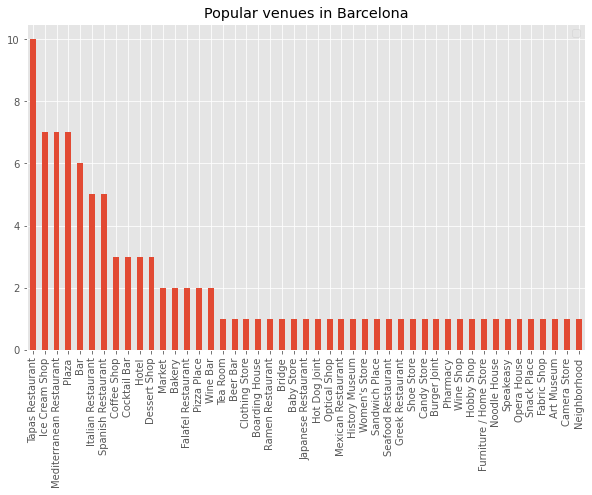

In [23]:
cat_diag1 = venues_cat[["Municipality", "Venue Category"]].loc[venues_cat["Municipality"]=="Barcelona"].set_index(["Municipality"])
cat_diag1.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.title("Popular venues in Barcelona")
plt.legend([])
plt.show()

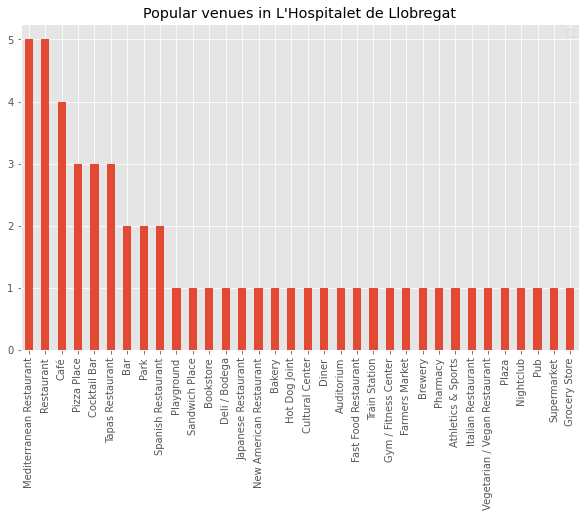

In [24]:
cat_diag2 = venues_cat[["Municipality", "Venue Category"]].loc[venues_cat["Municipality"]=="L'Hospitalet de Llobregat"].set_index(["Municipality"])
cat_diag2.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.title("Popular venues in L'Hospitalet de Llobregat")
plt.legend([])
plt.show()

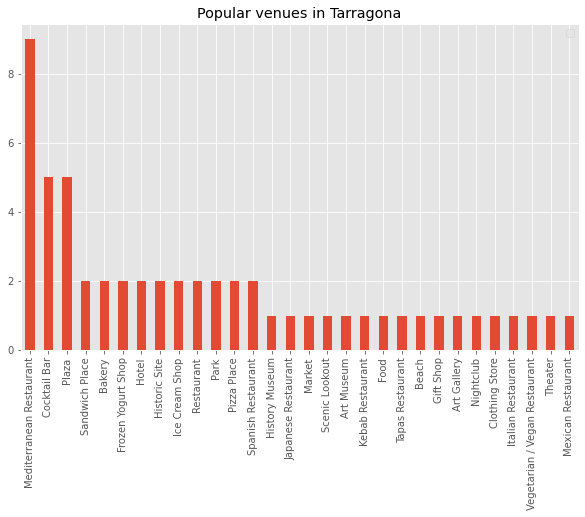

In [25]:
cat_diag3 = venues_cat[["Municipality", "Venue Category"]].loc[venues_cat["Municipality"]=="Tarragona"].set_index(["Municipality"])
cat_diag3.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.title("Popular venues in Tarragona")
plt.legend([])
plt.show()

Putting them all together into the same plot:

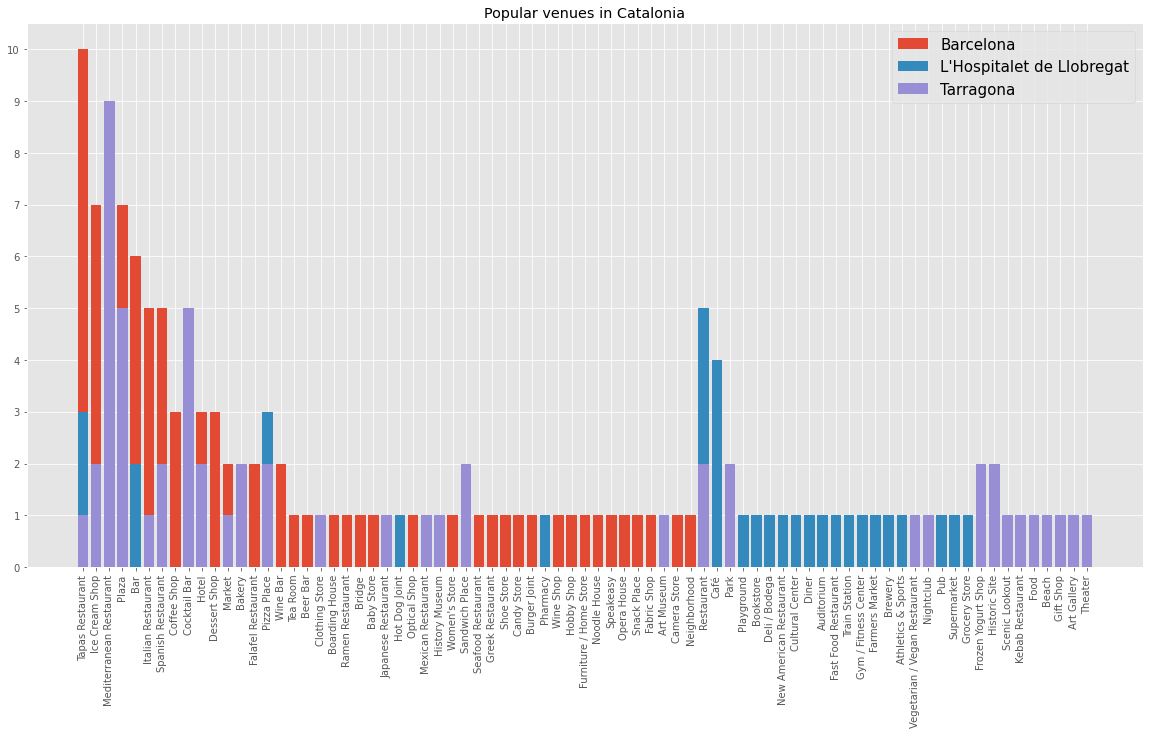

In [26]:
cat1 = cat_diag1.apply(pd.value_counts).rename(columns={"Venue Category":"Barcelona"})
cat2 = cat_diag2.apply(pd.value_counts).rename(columns={"Venue Category":"L'Hospitalet de Llobregat"})
cat3 = cat_diag3.apply(pd.value_counts).rename(columns={"Venue Category":"Tarragona"})
cat_tot = pd.concat([cat1, cat2, cat3])

plt.figure(figsize=(20,10))
plt.bar(cat1["Barcelona"].index, cat1["Barcelona"].values, label="Barcelona")
plt.bar(cat2["L'Hospitalet de Llobregat"].index, cat2["L'Hospitalet de Llobregat"].values, label="L'Hospitalet de Llobregat")
plt.bar(cat3["Tarragona"].index, cat3["Tarragona"].values, label="Tarragona")
plt.xticks(rotation=90)
plt.yticks(ticks=np.linspace(0,10,11))
plt.legend(prop={"size":15})
plt.title("Popular venues in Catalonia")
plt.show()

We can see that the most popular venues are usually restaurants or food/drink related venues, such as ice cream shops or cocktail bars.<br>
One of the categories that particularly stands out are mediterranean restaurants, which are extremely popular in Tarragona but are not that common in Barcelona or L'Hospitalet. Since Barcelona is also a coastal city, a mediterranean restaurant could be a good idea if we are looking for establishing a restaurant. <br>
Tapas restaurant show a similar situation; there are 10 popular related venues in Barcelona, but just 3 in L'Hospitalet and 1 in Tarragona. Clearly, there is an exploitable demand that one could take advantage from.  <br>
Cocktail bars are also worthy of study: they are common in Tarragona but not elsewhere. Considering that (as of 2019 and according to Google) Barcelona has roughly 7 times the population and a big leisure scene, consisting of clubs like Razzmatazz or Pacha Barcelona, it might be a good idea to establish a cocktail bar.

The venues that are not present on each municipality but are present in other municipalities are:

In [27]:
for mun in cat_freq["Municipality"]:
    print("--"+mun+"--")
    temp = cat_freq[cat_freq["Municipality"] == mun].T.reset_index()
    temp.columns = ['Venue','Frequency']
    print(temp.loc[temp["Frequency"] == 0].reset_index(drop=True))
    print('\n')

--Barcelona--
                            Venue Frequency
0                     Art Gallery         0
1              Athletics & Sports         0
2                      Auditorium         0
3                           Beach         0
4                       Bookstore         0
5                         Brewery         0
6                            Café         0
7                 Cultural Center         0
8                   Deli / Bodega         0
9                           Diner         0
10                 Farmers Market         0
11           Fast Food Restaurant         0
12                           Food         0
13             Frozen Yogurt Shop         0
14                      Gift Shop         0
15                  Grocery Store         0
16           Gym / Fitness Center         0
17                  Historic Site         0
18               Kebab Restaurant         0
19        New American Restaurant         0
20                      Nightclub         0
21                

### 3.2 Madrid
<a id='3.2'></a>

We repeat the same process for Madrid. The top 5 venues for each municipality are:

In [28]:
for mun in mad_freq["Municipality"]:
    print("--"+mun+"--")
    temp = mad_freq[mad_freq["Municipality"] == mun].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp["Frequency"] = temp["Frequency"].astype(float)
    temp = temp.round({"Frequency": 2})
    print(temp.sort_values("Frequency", ascending=False).reset_index(drop=True).head(5))
    print('\n')

--Alcobendas--
              Venue  Frequency
0            Bakery       0.12
1  Tapas Restaurant       0.08
2       Pizza Place       0.08
3              Park       0.08
4               Gym       0.04


--Boadilla del Monte--
                 Venue  Frequency
0   Spanish Restaurant       0.24
1   Light Rail Station       0.12
2   Italian Restaurant       0.12
3  Japanese Restaurant       0.06
4            Irish Pub       0.06


--Pozuelo de Alarcón--
                Venue  Frequency
0  Spanish Restaurant        0.4
1  Seafood Restaurant        0.2
2         Flea Market        0.2
3               Plaza        0.2
4         Art Gallery        0.0




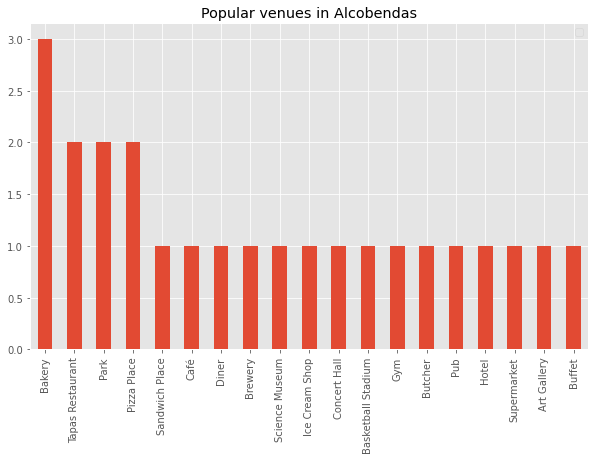

In [29]:
mad_diag1 = venues_mad[["Municipality", "Venue Category"]].loc[venues_mad["Municipality"]=="Alcobendas"].set_index(["Municipality"])
mad_diag1.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.legend([])
plt.title("Popular venues in Alcobendas")
plt.show()

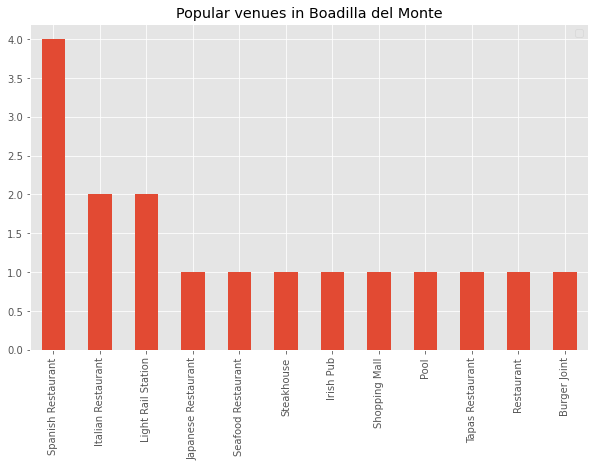

In [30]:
mad_diag2 = venues_mad[["Municipality", "Venue Category"]].loc[venues_mad["Municipality"]=="Boadilla del Monte"].set_index(["Municipality"])
mad_diag2.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.legend([])
plt.title("Popular venues in Boadilla del Monte")
plt.show()

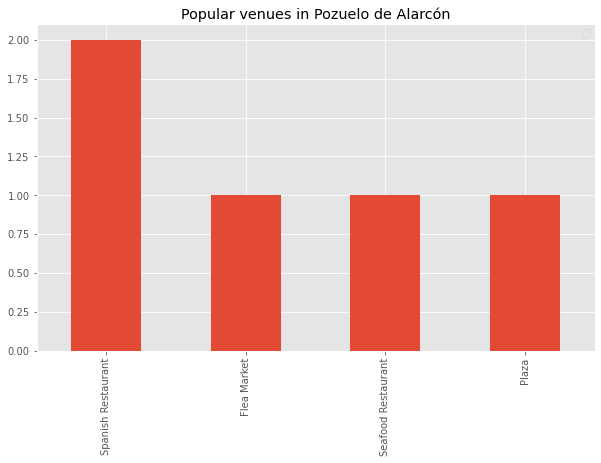

In [31]:
mad_diag3 = venues_mad[["Municipality", "Venue Category"]].loc[venues_mad["Municipality"]=="Pozuelo de Alarcón"].set_index(["Municipality"])
mad_diag3.apply(pd.value_counts).plot(kind="bar", figsize=(10,6))
plt.legend([])
plt.title("Popular venues in Pozuelo de Alarcón")
plt.show()

Joining them together, we get:

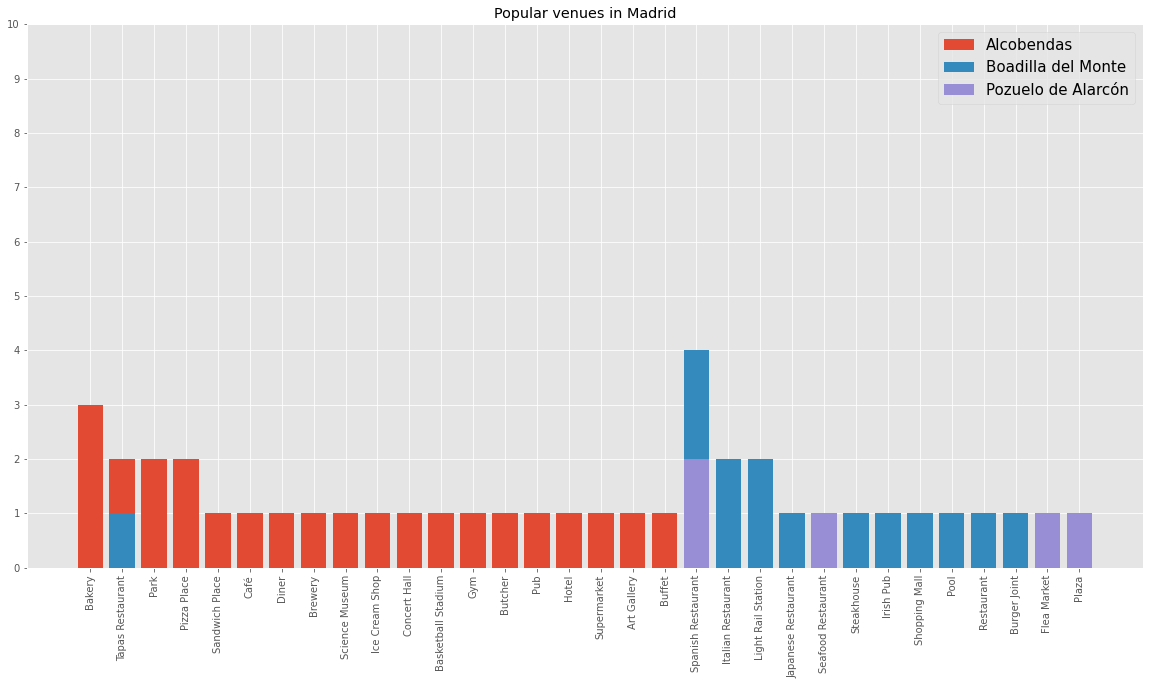

In [32]:
mad1 = mad_diag1.apply(pd.value_counts).rename(columns={"Venue Category":"Alcobendas"})
mad2 = mad_diag2.apply(pd.value_counts).rename(columns={"Venue Category":"Boadilla del Monte"})
mad3 = mad_diag3.apply(pd.value_counts).rename(columns={"Venue Category":"Pozuelo de Alarcón"})
mad_tot = pd.concat([mad1, mad2, mad3])

plt.figure(figsize=(20,10))
plt.bar(mad1["Alcobendas"].index, mad1["Alcobendas"].values, label="Alcobendas")
plt.bar(mad2["Boadilla del Monte"].index, mad2["Boadilla del Monte"].values, label="Boadilla del Monte")
plt.bar(mad3["Pozuelo de Alarcón"].index, mad3["Pozuelo de Alarcón"].values, label="Pozuelo de Alarcón")
plt.xticks(rotation=90)
plt.yticks(ticks=np.linspace(0,10,11))
plt.legend(prop={"size":15})
plt.title("Popular venues in Madrid")
plt.show()

Firstly, we can see that, unlike in the chosen municipalities from Catalonia, there are not that many venues in this case. This happens not because there is not a demand for venues, but because the overall population of these municipalities is really low when comparing it to the ones from Catalonia; as of 2018, and according to Google, Barcelona on its own is about 21.8 times more populated that all of the chosen municipalities for Madrid combined.

Just like before, restaurants and food related venues are the most popular.<br> 
We can find 3 popular bakeries in Alcobendas, but neither Boadilla nor Pozuelo have popular ones. Same thing happens with italian restaurants: there are 2 popular italian restaurants in Boadilla, but none on the other 2 municipalities. The latter in particular could present an interesting opportunity given the popularity of restaurants in the analysed regions. <br>
There's also the case of the tapas restaurants: just 2 popular ones in Alcobendas for our whole dataset. Previously, we saw that in Catalonia (specifically in Barcelona) these restaurants where amongst the most popular venues for the region. Tapas are one of the most identifiable appetizers in Spanish cuisine, and still, there are no popular tapas restaurants in Boadilla nor in Pozuelo. 

Finally, the non-present venues on each one are:

In [33]:
for mun in mad_freq["Municipality"]:
    print("--"+mun+"--")
    temp = mad_freq[mad_freq["Municipality"] == mun].T.reset_index()
    temp.columns = ['Venue','Frequency']
    print(temp.loc[temp["Frequency"] == 0].reset_index(drop=True))
    print('\n')

--Alcobendas--
                  Venue Frequency
0          Burger Joint         0
1           Flea Market         0
2             Irish Pub         0
3    Italian Restaurant         0
4   Japanese Restaurant         0
5    Light Rail Station         0
6                 Plaza         0
7                  Pool         0
8            Restaurant         0
9    Seafood Restaurant         0
10        Shopping Mall         0
11   Spanish Restaurant         0
12           Steakhouse         0


--Boadilla del Monte--
                 Venue Frequency
0          Art Gallery         0
1               Bakery         0
2   Basketball Stadium         0
3              Brewery         0
4               Buffet         0
5              Butcher         0
6                 Café         0
7         Concert Hall         0
8                Diner         0
9          Flea Market         0
10                 Gym         0
11               Hotel         0
12      Ice Cream Shop         0
13                Park

## 4. Clustering with KMeans
<a id='4'></a>

To conclude the analysis, we will run k-means to cluster the municipalitites by their popular venues. Since Foursquare's API classifies the venues based on the labels that we have already seen ("Tapas restaurant", "Pool"...), it could be interesting to set up a clustering algorithm that labels the venues in terms of the number of times they appear (their frequencies, which we have already discussed). We will do this for every one of the municipalities.

Judging from the previous bar plots, we can approximate the number of clusters for Catalonia and Madrid as 4, since the frequencies can be roughly divided into 4 general groups. However, this is not the case for Pozuelo de Alarcón, which clearly shows 3 distinct groups. 

Since we want a visual approach to the results of the algorithm, we will define a function that both applies KMeans and then plots the now labeled venues vs their frequencies. Its' parameters are a dataframe with the values of the frequencies of each venue, the municipality for which we want the analysis (as a string) and the number of clusters. To simplify the function and for the purposes of this project, the function will work for both 3 and 4 clusters, being 4 the default value.

**Note that, since the analysis is being carried out on separate municipalities, we will also run KMeans with each municipality as an unique dataset. Thus, the labels for each municipality are specific for each one of them. "Label 0" for Barcelona might be assigned to the higher-frequency values, while for the case of Tarragona it might be assigned to the lowest-frequency values. This is not a problem, given that what we care about is the distinction between venues of the same municipalities, not between municipalities.**

In [34]:
# Function that applies KMeans and then plots a dataframe with the frequencies of the venues

def plotKMeans(dataframe, municipality, k=4):
    
#KMEANS
    # Creates dataframe with the frequencies of each type of venue
    dataframe_cluster = dataframe.loc[dataframe["Municipality"]==municipality]
    dataframe_cluster = dataframe_cluster.drop("Municipality", axis=1).transpose()

    # Runs the KMeans algorithm for 4 clusters and then appends the labels to the dataframe
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=1).fit(dataframe_cluster)

    # Renames the columns
    dataframe_cluster.columns = ["Frequency"]
    dataframe_cluster["Cluster label"] = kmeans.labels_

    
#PLOT 
    plt.figure(figsize=(20,6))
    # For 4 clusters
    if k == 4:
        # Checks the label assigned by KMeans and plots the point with a specific color
        for i in range(0, dataframe_cluster.shape[0]):
            if dataframe_cluster["Cluster label"].iloc[i] == 0:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="red")
                continue

            if dataframe_cluster["Cluster label"].iloc[i] == 1:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="lawngreen")
                continue

            if dataframe_cluster["Cluster label"].iloc[i] == 2:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="gold")
                continue

            if dataframe_cluster["Cluster label"].iloc[i] == 3:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="darkred")
                continue

        plt.xticks(rotation=90)
        plt.ylabel("Frequency", labelpad=15, fontsize=17)
        plt.yticks(np.linspace(min(dataframe_cluster["Frequency"].values), max(dataframe_cluster["Frequency"].values), 11))
        plt.legend(handles=[
            mpatches.Patch(color='red', label='Label 0'),
            mpatches.Patch(color='lawngreen', label='Label 1'),
            mpatches.Patch(color='gold', label='Label 2'),
            mpatches.Patch(color='darkred', label='Label 3')
            ],
                  fontsize=12)
        
    # For 3 clusters
    elif k == 3:
        # Checks the label assigned by KMeans and plots the point with a specific color
        for i in range(0, dataframe_cluster.shape[0]):
            if dataframe_cluster["Cluster label"].iloc[i] == 0:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="red")
                continue

            if dataframe_cluster["Cluster label"].iloc[i] == 1:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="lawngreen")
                continue

            if dataframe_cluster["Cluster label"].iloc[i] == 2:
                plt.scatter(dataframe_cluster.index[i], dataframe_cluster["Frequency"].values[i], c="gold")
                continue

        plt.xticks(rotation=90)
        plt.ylabel("Frequency", labelpad=15, fontsize=17)
        plt.yticks(np.linspace(min(dataframe_cluster["Frequency"].values), max(dataframe_cluster["Frequency"].values), 11))
        plt.legend(handles=[
            mpatches.Patch(color='red', label='Label 0'),
            mpatches.Patch(color='lawngreen', label='Label 1'),
            mpatches.Patch(color='gold', label='Label 2'),
            ])
        
    plt.title("Labeled venues vs their frequency in " + municipality)
    plt.show()
    

### 4.1 Catalonia
<a id='4.1'></a>

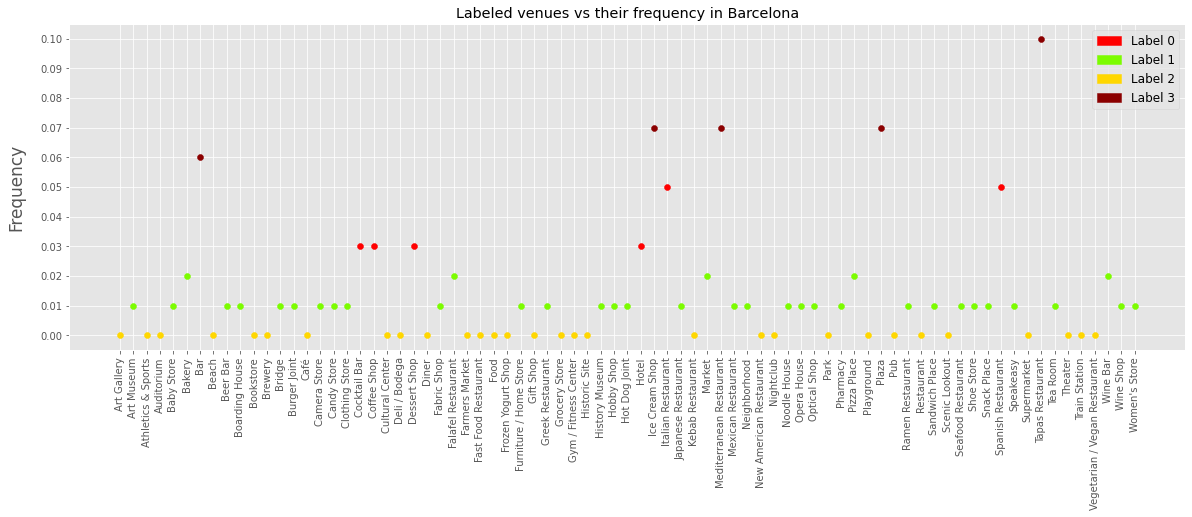

In [35]:
plotKMeans(cat_freq, "Barcelona")

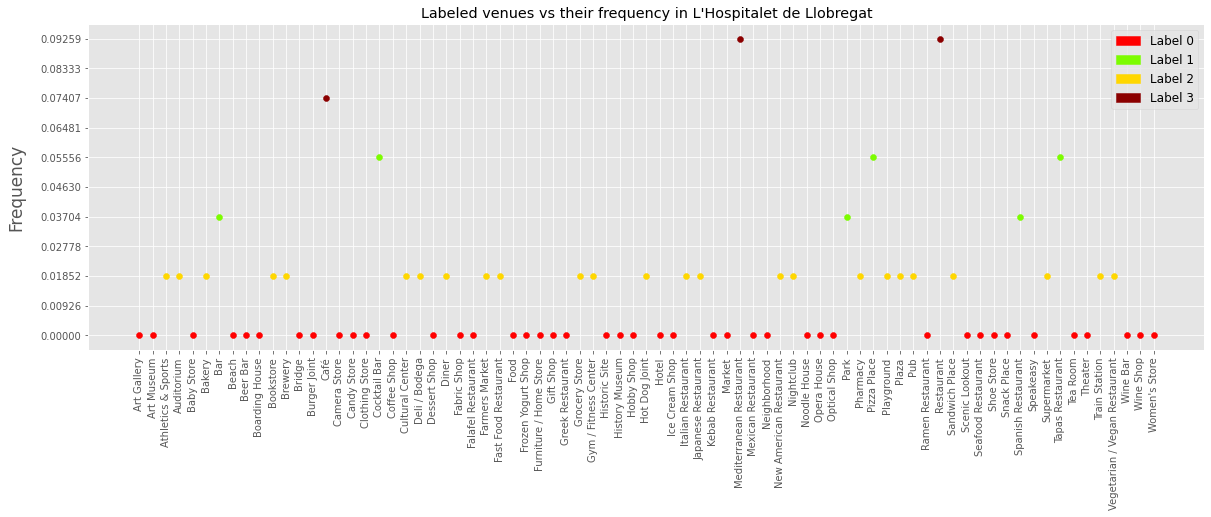

In [36]:
plotKMeans(cat_freq, "L'Hospitalet de Llobregat")

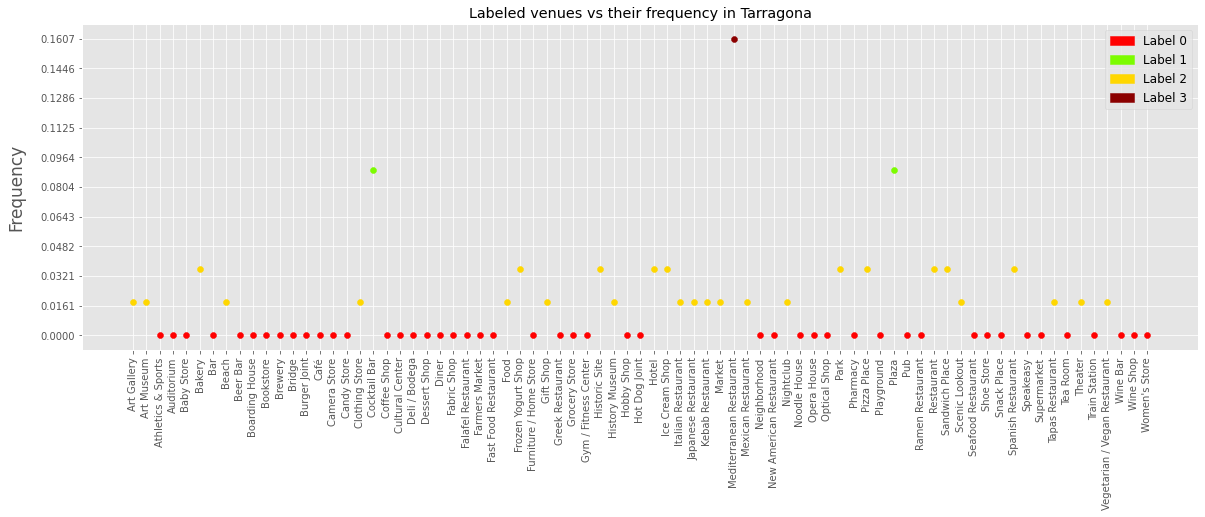

In [37]:
plotKMeans(cat_freq, "Tarragona")

### 4.2 Madrid
<a id='4.2'></a>

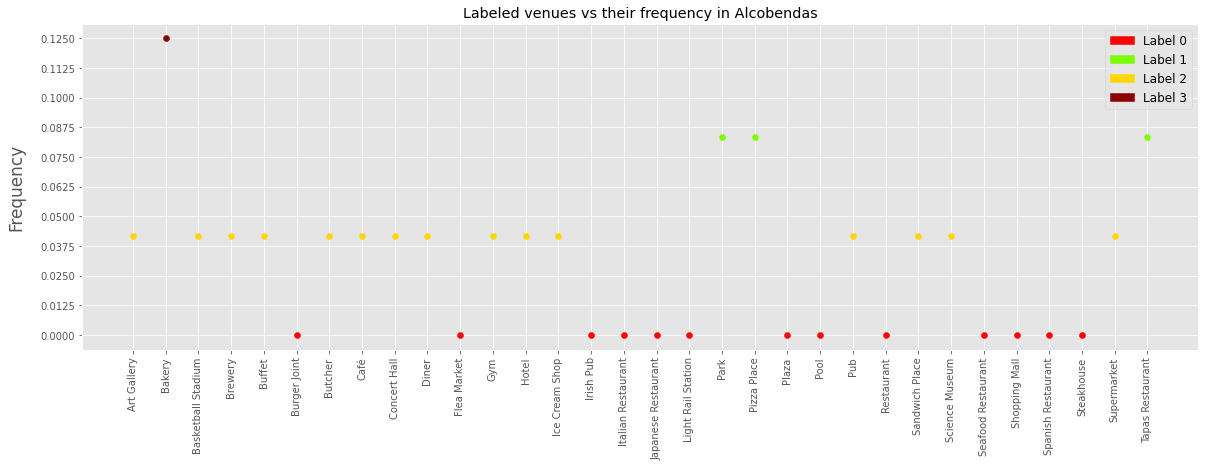

In [38]:
plotKMeans(mad_freq, "Alcobendas")

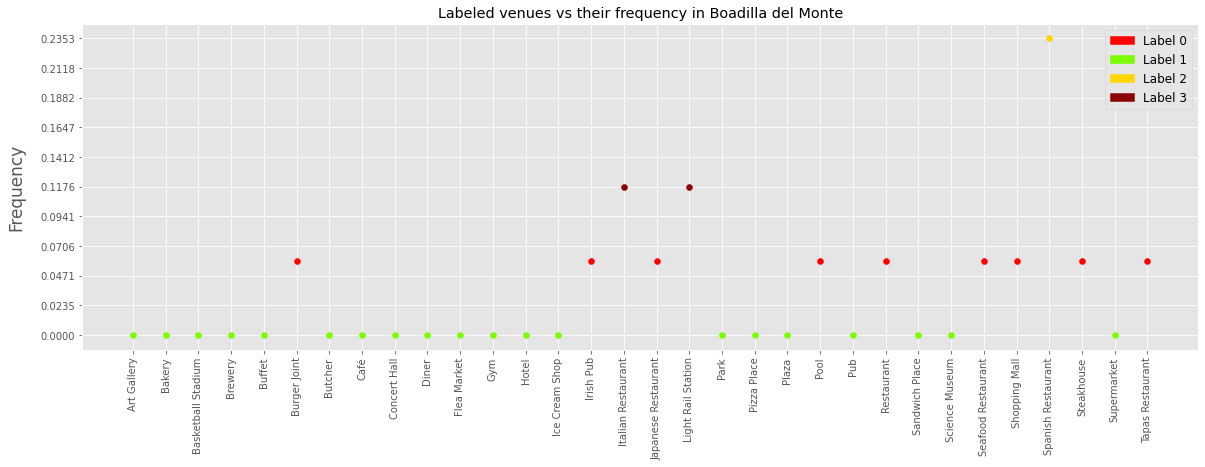

In [39]:
plotKMeans(mad_freq, "Boadilla del Monte")

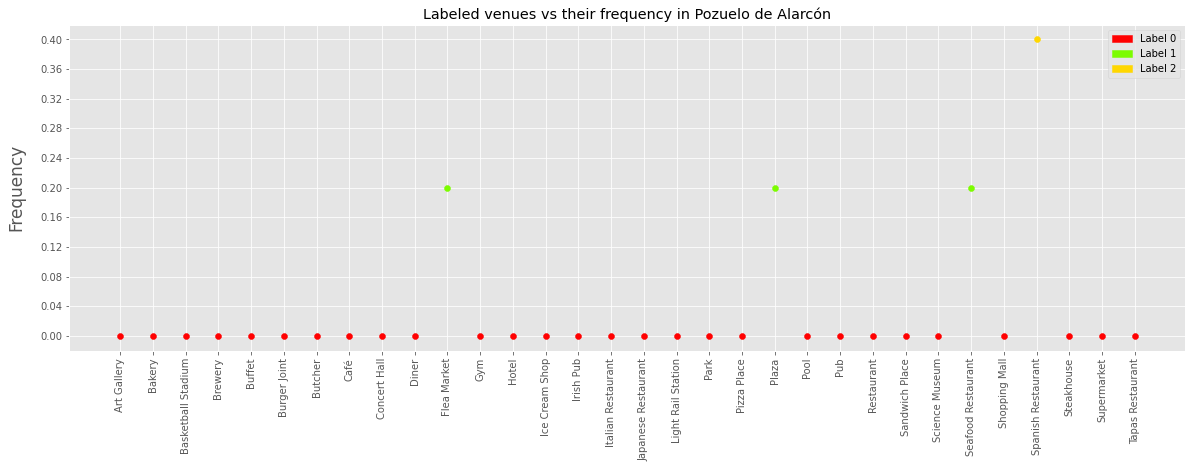

In [40]:
plotKMeans(mad_freq, "Pozuelo de Alarcón", k=3)

## 5. Conclusion
<a id='5'></a>

The main objective of the project was to analyse the most popular venues of the regions of Spain that contribute the most to its' GDP: Madrid and Catalonia. This way, we can get a general idea of the most successfull ones and propose a potentially exploitable demand in certain venue categories.<br>
First, we needed the GDP-related data for the municipalities of each autonomous community. This was possible thanks to web scraping with BeautifulSoup. Then, after cleaning the datasets, we took the top 3 that contribute the most to the Spanish GDP and located them with Geopy.<br>
Once that was done, we used Foursquare's API to get the most popular venue categories in each municipality. We calculated their frequencies and then plotted them to compare the results in Catalonia and Madrid.<br>
Finally, to label each venue category in terms of their frequency, we used a clustering algorithm: KMeans. Later on, the venues were replotted with their labels.

From the datasets, we gathered that restaurants are typically the most popular venues throughout the regions.<br>
In the case of Catalonia, tapas restaurant turned out to be really trendy, alongside with mediterranean restaurants, ice cream shops or Spanish restaurants. Some of the most promising cases were discussed.<br>
For Madrid, the number of venues was smaller since the population of its' chosen municipalities is also smaller than the ones chosen for Catalonia. Food related venues were also the most popular, with categories such as Bakeries, Spanish and Italian restaurants or, the most popular in Catalonia, the tapas restaurants, the latter showing just 2 popular cases while in Catalonia there were 14 of them.<br>

From this, we can infer that even though the population changes, restaurants typically remain as the trendiest venues. Some of the most successful categories in certain municipalities are not present in others, and could present a potential business opportunity. 